In [76]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from tensorflow.keras.regularizers import l2
import joblib

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configure plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

In [77]:
# Load the dataset
df = pd.read_csv('../data/final_output.csv')

# Display basic information
print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
df.head()

Dataset Shape: (3063, 11)

First few rows:


,car_age,year,owner,km_driven,brand_name_Mahindra,brand_name_Tata,brand_name_Toyota,brand_popularity,brand_name_Honda,brand_name_Chevrolet,selling_price
0,0.684211,0.315789,0,0.421683,0.0,0.0,0.0,1.000000,0.0,0.0,60000.000000
1,0.684211,0.315789,0,0.301201,0.0,0.0,0.0,1.000000,0.0,0.0,504355.832295
2,0.421053,0.578947,0,0.602407,0.0,0.0,0.0,0.578947,0.0,0.0,600000.000000
3,0.157895,0.842105,0,0.277104,0.0,0.0,0.0,0.026316,0.0,0.0,250000.000000
4,0.315789,0.684211,2,0.849397,0.0,0.0,0.0,0.188259,1.0,0.0,450000.000000


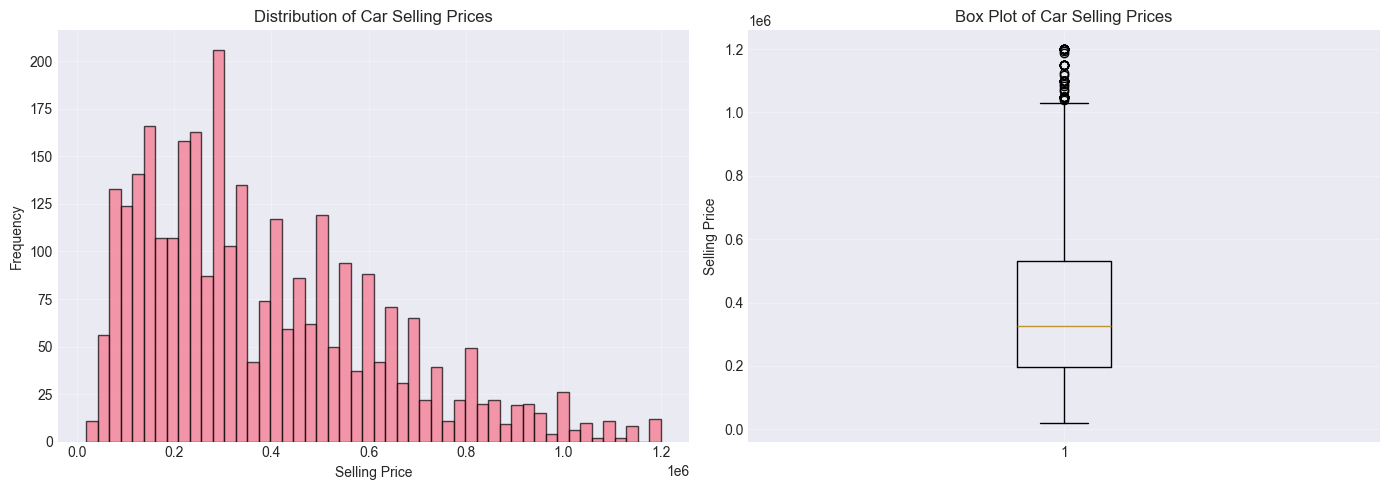

In [78]:
# Distribution of target variable
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(df['selling_price'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Selling Price')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Car Selling Prices')
axes[0].grid(True, alpha=0.3)

# Box plot
axes[1].boxplot(df['selling_price'])
axes[1].set_ylabel('Selling Price')
axes[1].set_title('Box Plot of Car Selling Prices')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [79]:
# Separate features and target
X = df.drop('selling_price', axis=1)
y = df['selling_price']

print("Features shape:", X.shape)
print("Target shape:", y.shape)
print("\nFeature columns:")
print(X.columns.tolist())

Features shape: (3063, 10)
Target shape: (3063,)

Feature columns:
['car_age', 'year', 'owner', 'km_driven', 'brand_name_Mahindra', 'brand_name_Tata', 'brand_name_Toyota', 'brand_popularity', 'brand_name_Honda', 'brand_name_Chevrolet']


In [80]:
# --- 1. Data Preparation and 80/20 Split ---

# Separate features and target
X = df.drop('selling_price', axis=1)
y = df['selling_price']

# 80% Train, 20% Test Split (Required for assignment)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Dataset Shape:", df.shape)
print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])

Dataset Shape: (3063, 11)
Training set size: 2450
Test set size: 613


In [81]:
# Scale the target variable (Crucial for deep learning regression)
target_scaler = StandardScaler()
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1)).flatten()
print("\nTarget variable scaled successfully")


Target variable scaled successfully


In [82]:
# --- 2. Model Creation Function (Allows Hyperparameter Tuning) ---

def create_mlp_model(input_dim, learning_rate, architecture, dropout_rate, l2_reg=0.0):
    """ Create a Multi-Layer Perceptron model with tunable hyperparameters. """
    model = keras.Sequential()
    model.add(layers.Input(shape=(input_dim,)))
    
    for i, units in enumerate(architecture):
        # Apply L2 regularization here
        model.add(layers.Dense(units, activation='relu', kernel_initializer='he_normal', 
                               kernel_regularizer=l2(l2_reg)))
        model.add(layers.BatchNormalization())
        if dropout_rate > 0:
            model.add(layers.Dropout(dropout_rate))

    # Output layer (1 neuron, no activation for regression)
    model.add(layers.Dense(1))

    # Compile model
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae', 'mse'])
    return model

# --- 3. Implement Three Model Varieties (Hyperparameter Tuning) ---

input_dim = X_train.shape[1]
all_models = {}
metrics_results = []
epochs_limit = 100 # Reduced max epochs for demonstration
batch_size = 128

# Define callbacks (Used for all models for fair comparison)
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=0)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7, verbose=0)


# --- Variety 1: Baseline (Deeper, Standard LR, Low Dropout) ---
print("\n--- Training Model Variety 1: Baseline (Deep Architecture) ---")
model_1 = create_mlp_model(input_dim, 
                           learning_rate=0.001, 
                           architecture=[256, 128, 64], # Deeper
                           dropout_rate=0.2)

history_1 = model_1.fit(
    X_train, y_train_scaled,
    validation_split=0.2, 
    epochs=epochs_limit, batch_size=batch_size,
    callbacks=[early_stopping, reduce_lr], verbose=0
)
all_models['Model 1 (Deep/LR=0.001)'] = model_1


# --- Variety 2: Shallower Architecture, Higher LR, Higher Dropout ---
print("--- Training Model Variety 2: Shallower (Fewer Layers, Faster LR) ---")
model_2 = create_mlp_model(input_dim, 
                           learning_rate=0.005, # Higher LR
                           architecture=[128, 64], # Shallower
                           dropout_rate=0.3) # Higher Dropout

history_2 = model_2.fit(
    X_train, y_train_scaled,
    validation_split=0.2,
    epochs=epochs_limit, batch_size=batch_size,
    callbacks=[early_stopping, reduce_lr], verbose=0
)
all_models['Model 2 (Shallow/LR=0.005)'] = model_2


# --- Variety 3: Lower LR, L2 Regularization, Different Architecture ---
print("--- Training Model Variety 3: Regularized (L2, Slower LR) ---")
model_3 = create_mlp_model(input_dim, 
                           learning_rate=0.0005, # Lower LR
                           architecture=[128, 64, 32, 16], # Different Deep Architecture
                           dropout_rate=0.1,
                           l2_reg=0.0001) # Added L2 Regularization

history_3 = model_3.fit(
    X_train, y_train_scaled,
    validation_split=0.2,
    epochs=epochs_limit, batch_size=batch_size,
    callbacks=[early_stopping, reduce_lr], verbose=0
)
all_models['Model 3 (Reg/LR=0.0005)'] = model_3



--- Training Model Variety 1: Baseline (Deep Architecture) ---
--- Training Model Variety 2: Shallower (Fewer Layers, Faster LR) ---
--- Training Model Variety 3: Regularized (L2, Slower LR) ---


In [83]:
# --- 4. Evaluation Function ---

def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {'R2': r2, 'RMSE': rmse, 'MAE': mae}

# --- 5. Evaluate and Compare All Models on Test Set ---
for name, model in all_models.items():
    # Predict and Inverse Transform
    y_test_pred_scaled = model.predict(X_test, verbose=0)
    y_test_pred = target_scaler.inverse_transform(y_test_pred_scaled).flatten()
    
    # Calculate metrics
    metrics = calculate_metrics(y_test, y_test_pred)
    
    print(f"\n--- Results for {name} ---")
    print(f"R² Score: {metrics['R2']:.4f}")
    print(f"RMSE: ${metrics['RMSE']:,.2f}")
    print(f"MAE: ${metrics['MAE']:,.2f}")
    
    metrics['Model'] = name
    metrics_results.append(metrics)

# Create metrics comparison dataframe and format for Markdown
comparison_df = pd.DataFrame(metrics_results).set_index('Model')
best_model_name = comparison_df['R2'].idxmax()

# Apply the .map() fix to avoid the FutureWarning
comparison_df_formatted = comparison_df.map(lambda x: f'${x:,.2f}' if isinstance(x, (int, float)) and x > 1 else f'{x:.4f}')

print("\nFull Comparison Table:")
print(comparison_df_formatted.to_markdown())

print("\nConclusion:")
print(f"The best performing variety is **{best_model_name}**, achieving the highest R² score on the test set.")


--- Results for Model 1 (Deep/LR=0.001) ---
R² Score: 0.5422
RMSE: $163,559.77
MAE: $122,145.57

--- Results for Model 2 (Shallow/LR=0.005) ---
R² Score: 0.5533
RMSE: $161,576.18
MAE: $121,646.60

--- Results for Model 3 (Reg/LR=0.0005) ---
R² Score: 0.5517
RMSE: $161,850.36
MAE: $123,026.52

Full Comparison Table:
| Model                      |     R2 | RMSE        | MAE         |
|:---------------------------|-------:|:------------|:------------|
| Model 1 (Deep/LR=0.001)    | 0.5422 | $163,559.77 | $122,145.57 |
| Model 2 (Shallow/LR=0.005) | 0.5533 | $161,576.18 | $121,646.60 |
| Model 3 (Reg/LR=0.0005)    | 0.5517 | $161,850.36 | $123,026.52 |

Conclusion:
The best performing variety is **Model 2 (Shallow/LR=0.005)**, achieving the highest R² score on the test set.


/var/folders/n3/qqjc_tk90qn8tzy1mvjvm7w80000gn/T/ipykernel_24645/315617190.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='R2', data=comparison_plot_data, ax=axes[0], palette='viridis')
/var/folders/n3/qqjc_tk90qn8tzy1mvjvm7w80000gn/T/ipykernel_24645/315617190.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='RMSE', data=comparison_plot_data, ax=axes[1], palette='plasma')
/var/folders/n3/qqjc_tk90qn8tzy1mvjvm7w80000gn/T/ipykernel_24645/315617190.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model'

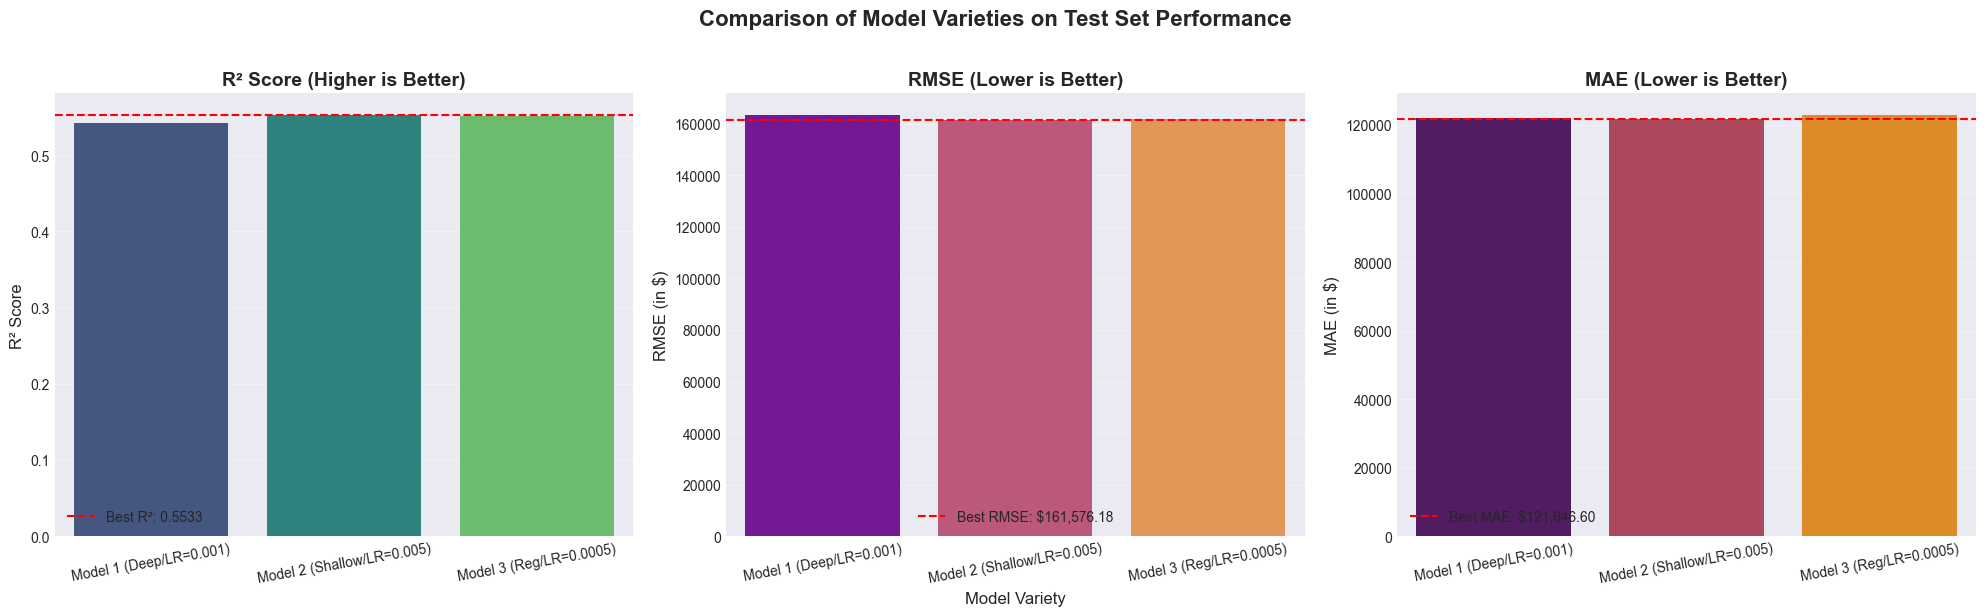

In [84]:
# --- 6. Comparison Plot (Updated to 3 separate panels for clarity) ---

comparison_plot_data = comparison_df.reset_index()

fig, axes = plt.subplots(1, 3, figsize=(20, 6)) # 1 row, 3 columns

# Plot 1: R² Score Comparison
sns.barplot(x='Model', y='R2', data=comparison_plot_data, ax=axes[0], palette='viridis')
best_r2 = comparison_plot_data['R2'].max()
axes[0].axhline(best_r2, color='r', linestyle='--', label=f'Best R²: {best_r2:.4f}')
axes[0].set_title('R² Score (Higher is Better)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('R² Score', fontsize=12)
axes[0].set_xlabel('')
axes[0].tick_params(axis='x', rotation=10)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: RMSE (Root Mean Squared Error) Comparison
sns.barplot(x='Model', y='RMSE', data=comparison_plot_data, ax=axes[1], palette='plasma')
best_rmse = comparison_plot_data['RMSE'].min()
axes[1].axhline(best_rmse, color='r', linestyle='--', label=f'Best RMSE: ${best_rmse:,.2f}')
axes[1].set_title('RMSE (Lower is Better)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('RMSE (in $)', fontsize=12)
axes[1].set_xlabel('Model Variety', fontsize=12)
axes[1].tick_params(axis='x', rotation=10)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

# Plot 3: MAE (Mean Absolute Error) Comparison
sns.barplot(x='Model', y='MAE', data=comparison_plot_data, ax=axes[2], palette='inferno')
best_mae = comparison_plot_data['MAE'].min()
axes[2].axhline(best_mae, color='r', linestyle='--', label=f'Best MAE: ${best_mae:,.2f}')
axes[2].set_title('MAE (Lower is Better)', fontsize=14, fontweight='bold')
axes[2].set_ylabel('MAE (in $)', fontsize=12)
axes[2].set_xlabel('')
axes[2].tick_params(axis='x', rotation=10)
axes[2].legend()
axes[2].grid(axis='y', alpha=0.3)


plt.suptitle('Comparison of Model Varieties on Test Set Performance', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


In [85]:
# --- 7. Final Model Saving ---
best_model = all_models[best_model_name]
best_model.save('../results/outputs/IT24103033_mlp_best_model.h5')
joblib.dump(target_scaler, 'target_scaler.pkl')
print(f"\nBest Model ({best_model_name}) saved as 'IT24103033_mlp_best_model.h5'")
print("Target scaler saved as '../results/outputs/target_scaler.pkl'")


Best Model (Model 2 (Shallow/LR=0.005)) saved as 'IT24103033_mlp_best_model.h5'
Target scaler saved as '../results/outputs/target_scaler.pkl'
